In [85]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.visualization import quantity_support
quantity_support()

from libstarcam import (
    InterpolatableTable,
    Filter, Lens, Sensor, StarCamera,
    get_filter_transmission, get_optics_transmission,
    simple_snr_spectral
)

%matplotlib widget

In [86]:
lambd = np.arange(400, 1010, 10) * u.nm
F0 = 1.2e-12 * u.W / (u.cm**2) / u.um # I-band, McLean 2008, Table 9.4

# filter library
nofilter = Filter(F0) # technically wrong, not good approximation to I-band
red650 = Filter(
    F0, # not a bad match to I-band filter?
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=650*u.nm, width=7*u.nm, max_transmission=0.9)),
)
black760 = Filter(
    F0, # technically wrong, not good approximation to I-band
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=760*u.nm, width=7*u.nm, max_transmission=0.9)),
)
various = [Filter(
    F0, # technically wrong, not good approximation to I-band
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=l, width=7*u.nm, max_transmission=0.9)),
) for l in lambd]

# lens library
canon_200_28 = Lens(
    200 * u.mm,
    200 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2.8'
)
canon_200_2 = Lens(
    200 * u.mm,
    200 * u.mm / 2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2'
)
canon_135_2 = Lens(
    135 * u.mm,
    135 * u.mm / 2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    cost=1300.,
    name='Canon 135mm f/2'
)

# sensor library
ui_3260 = Sensor(
    (1936, 1216),
    5.86 * u.um,
    0.35/u.s, # http://neutronoptics.com/soft/Manual-NeutronOptics-FLIR-CMOS-Camera.pdf
    21,
    8,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.58, 0.77, 0.61, 0.5, 0.39, 0.29, 0.2, 0.03, 0.0, 0.0])
    ),
    cost=688.,
    name='iDS uEye UI-3260-CP-M-GL'
)
u3_31n0se = Sensor(
    (5328,3040),
    2.74*u.um,
    1.38/u.s, # https://thinklucid.com/product/triton-16-2-mp-imx542/?srsltid=AfmBOorWeS_UYDtT8ZuoNhhgyEVhc7NRxoBQiFOYLiM8PHZ1PaTqk6eL
    1, # https://www.ximea.com/products/usb-vision-industrial/xic-sony-cmos-pregius-usb3-cameras/sony-imx542-usb3-color-industrial-camera
    8, # real capability is 12-bit, but we might run in 8-bit for software reasons
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.62, 0.72, 0.6, 0.53, 0.43, 0.34, 0.24, 0.04, 0.0, 0.0])
    ),
    cost=1700.,
    name='iDS uEye U3-31N0SE-M-GL'
)
asi183mm = Sensor(
    (5496,3672),
    2.4*u.um,
    1.56/u.s, # @30 C, also the max measured value
    1.6,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        0.84 * np.array([0.7, 0.96, 0.93, 0.8, 0.73, 0.45, 0.25, 0.09, 0.0, 0.0])
    ),
    cost=999.,
    name='ZWO ASI183MM'
)
asi294mm = Sensor( # hardware binning 2x
    (4144,2822),
    4.64*u.um,
    0.185/u.s, # copied from qhy model below
    1.2,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.64, 0.89, 0.86, 0.66, 0.44, 0.3, 0.1, 0.0, 0.0])
    ), # https://www.highpointscientific.com/media/wysiwyg/zwo-asi294mm-peak-qe_1.jpg
    cost=699.,
    name='ZWO ASI294MM (IMX492)'
)
qhy294m = Sensor(
    (4164,2796),
    4.63*u.um,
    0.185/u.s,
    6.34,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.7489, 0.8555, 0.6699, 0.4069, 0.2478, 0.1048, 0.0036, 0.0, 0.0])
    ), # https://thinklucid.com/product/atlas10-47mp-imx492/?srsltid=AfmBOopZ_X-HADsVjUXdADE_B9aT_rG-wxSMF7FPXXMrn-KGeBVtj6wP
    cost=1299.,
    name='QHY294M (IMX492)'
)
qhy5iii585m = Sensor(
    (3856,2180),
    2.9*u.um,
    0.518/u.s, # @30 C, the max
    8,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.91, 0.91, 0.88, 0.76, 0.58, 0.38, 0.16, 0.0, 0.0])
    ), # https://www.qhyccd.com/minicam8/
    cost=349.,
    name='QHY5III585M (IMX585)'
) # https://player-one-astronomy.com/product/uranus-c-pro-usb3-0-color-camera-imx585/
qhy268 = Sensor(
    (6252,4176),
    3.76*u.um,
    0.0369/u.s, # @20 C, the max
    3.5,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.72, 0.90, 0.72, 0.46, 0.28, 0.15, 0.04, 0.0, 0.0])
    ), # https://www.qhyccd.com/astronomical-camera-qhy268/
    cost=2399.,
    name='QHY268M'
)
qhy533 = Sensor(
    (3008,3028),
    3.76*u.um,
    0.0005/u.s, # @-20 C, no other data/I'm lazy/doesn't matter
    3.4,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.72, 0.90, 0.72, 0.46, 0.28, 0.15, 0.04, 0.0, 0.0])
    ), # https://www.qhyccd.com/astronomical-camera-qhy533/, same QE as 268?
    cost=1099.,
    name='QHY533M'
)
qhy183 = Sensor(
    (5544,3684),
    2.4*u.um,
    0.062/u.s, # @15 C, the max
    2.7,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.74, 0.84, 0.65, 0.43, 0.24, 0.11, 0.04, 0.0, 0.0])
    ), # https://cloudbreakoptics.com/blogs/news/product-review-the-qhy-183c
    cost=999.,
    name='QHY183M (IMX183)'
)

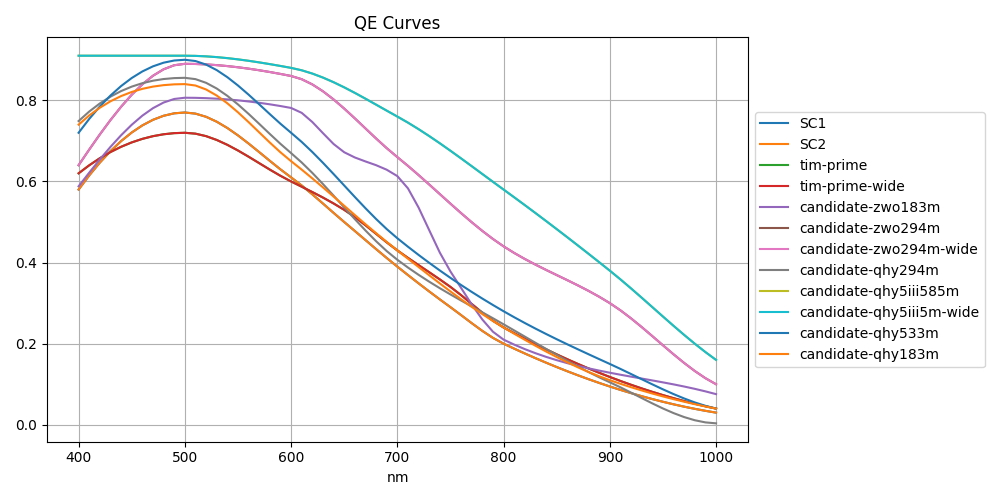

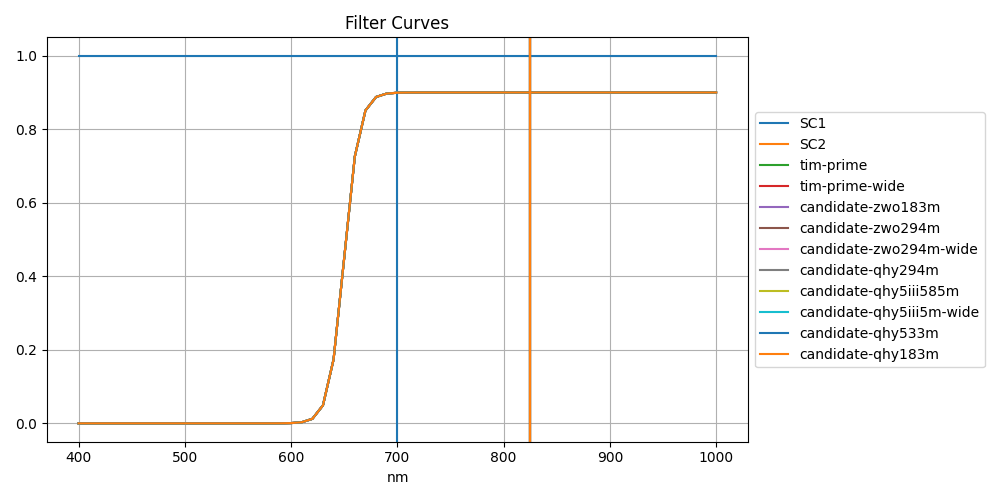

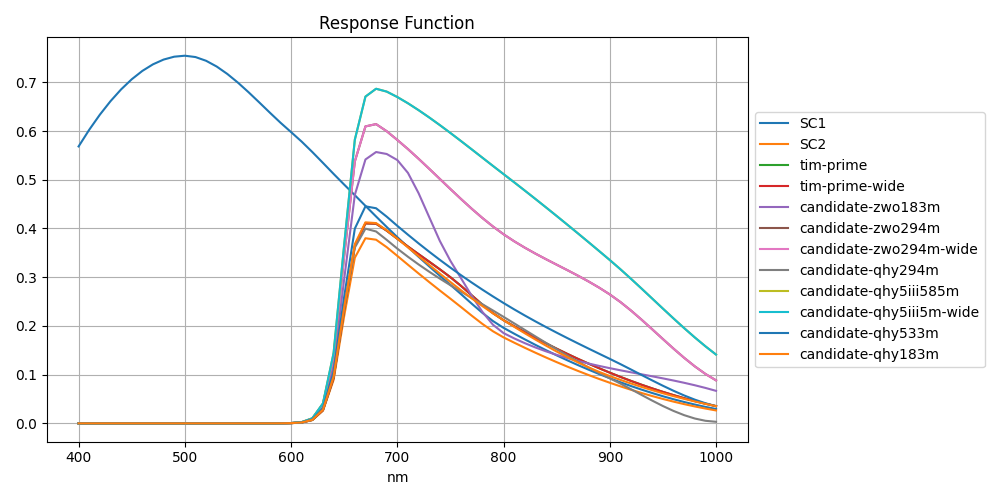

In [87]:
SC1 = StarCamera(ui_3260, canon_200_28, nofilter, name='SC1')
SC2 = StarCamera(ui_3260, canon_200_28, red650, name='SC2')
tim_prime = StarCamera(u3_31n0se, canon_200_28, red650, name='tim-prime')
tim_prime_wide = StarCamera(u3_31n0se, canon_135_2, red650, name='tim-prime-wide')
cam_zwo183m = StarCamera(asi183mm, canon_200_28, red650, name='candidate-zwo183m')
cam_zwo294m = StarCamera(asi294mm, canon_200_28, red650, name='candidate-zwo294m')
cam_zwo294m_wide = StarCamera(asi294mm, canon_135_2, red650, name='candidate-zwo294m-wide')
cam_qhy294m = StarCamera(qhy294m, canon_200_28, red650, name='candidate-qhy294m')
cam_qhy5iii585m = StarCamera(qhy5iii585m, canon_200_28, red650, name='candidate-qhy5iii585m')
cam_qhy5iii585m_wide = StarCamera(qhy5iii585m, canon_135_2, red650, name='candidate-qhy5iii5m-wide')
cam_qhy268m = StarCamera(qhy268, canon_200_28, red650, name='candidate-qhy268m')
cam_qhy533m = StarCamera(qhy533, canon_200_28, red650, name='candidate-qhy533m')
cam_qhy183m = StarCamera(qhy183, canon_200_28, red650, name='candidate-qhy183m')

cams = [SC1, SC2, tim_prime, tim_prime_wide, cam_zwo183m, cam_zwo294m, cam_zwo294m_wide, cam_qhy294m, cam_qhy5iii585m, cam_qhy5iii585m_wide, cam_qhy533m, cam_qhy183m]

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(lambd, cam.sensor.qe(lambd), color=color, label=cam.name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('QE Curves')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(lambd, cam.filter.tau(lambd), color=color, label=cam.name)
    ax.axvline(cam.get_mean_lambd(lambd), color=color)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('Filter Curves')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    ax.plot(lambd, cam.get_response(lambd), label=cam.name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('Response Function')
fig.tight_layout()

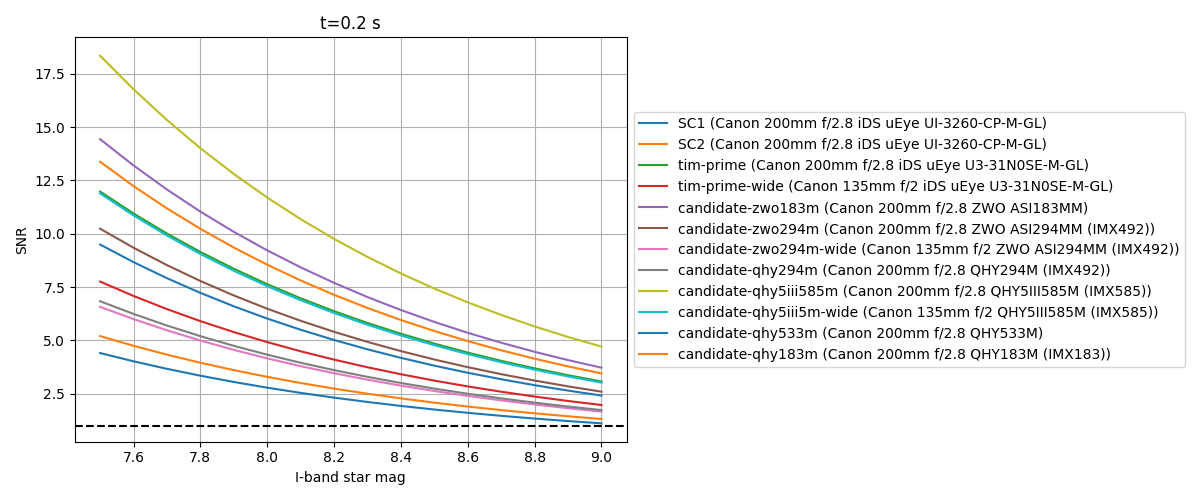

In [94]:
fig, ax = plt.subplots(figsize=(12,5))

t_exp = 0.2 * u.s
mags = np.arange(9, 7.4, -0.1)
for cam in cams:
    snrs = []
    for mag in mags:
        snrs.append(simple_snr_spectral(t_exp, lambd, mag, cam))
    ax.plot(mags, snrs, label=f'{cam.name} ({cam.lens.name} {cam.sensor.name})')
ax.axhline(1, linestyle='--', color='k')
ax.set_xlabel('I-band star mag')
ax.set_ylabel('SNR')
ax.set_title(f't={t_exp:0.1f}')
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

SC1: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2
SC2: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2
tim-prime: [4.18036976 2.38590979] deg -> 9.97398514624117 deg2
tim-prime-wide: [6.18986189 3.53407114] deg -> 21.875412292075133 deg2
candidate-zwo183m: [3.77740244 2.52427285] deg -> 9.535194419026121 deg2
candidate-zwo294m: [5.50422503 3.74983855] deg -> 20.63995523103358 deg2
candidate-zwo294m-wide: [8.14693039 5.55294952] deg -> 45.239493159657826 deg2
candidate-qhy294m: [5.51884742 3.70731284] deg -> 20.460093901218883 deg2
candidate-qhy5iii585m: [3.20268746 1.81096881] deg -> 5.799967088052112 deg2
candidate-qhy5iii5m-wide: [4.74324716 2.68264995] deg -> 12.724471735202739 deg2
candidate-qhy533m: [3.23923619 3.26076208] deg -> 10.562378541579752 deg2
candidate-qhy183m: [3.81036865 2.53251942] deg -> 9.649832615617715 deg2


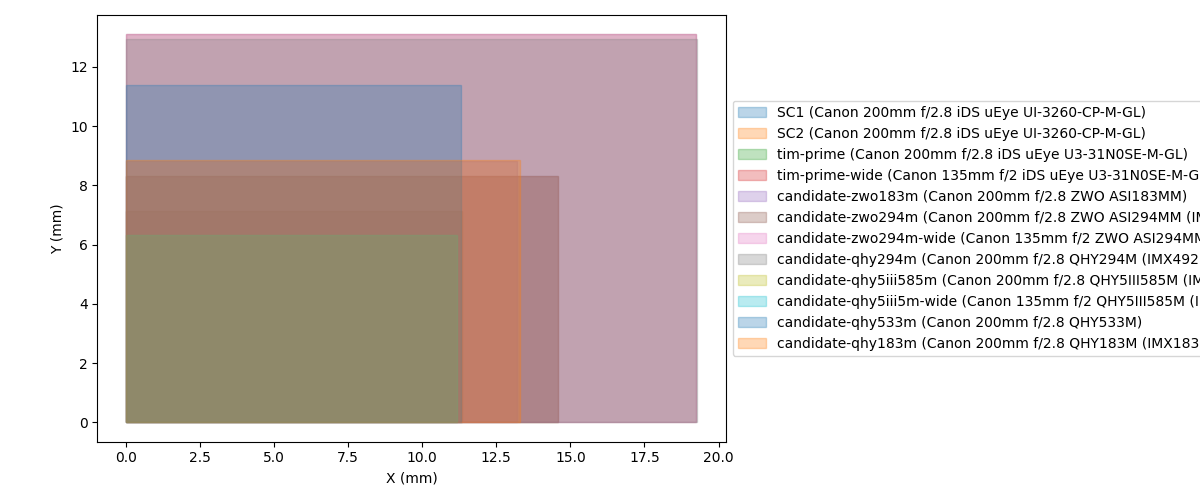

In [89]:
fig, ax = plt.subplots(figsize=(12,5))
for i, cam in enumerate(cams):
    ax.add_artist(
        Rectangle(
            (0, 0),
            cam.sensor.sensor_size[0].value,
            cam.sensor.sensor_size[1].value,
            color=f'C{i}',
            label=f'{cam.name} ({cam.lens.name} {cam.sensor.name})',
            alpha=0.3
        ),
    )
    print(f'{cam.name}: {cam.fov} -> {cam.fov[0] * cam.fov[1]}')
ax.relim()
ax.autoscale_view()
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
fig.tight_layout()

SC1: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2 -> 3.3160959680988733 stars
SC2: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2 -> 3.3160959680988733 stars
tim-prime: [4.18036976 2.38590979] deg -> 9.97398514624117 deg2 -> 4.986992573120585 stars
tim-prime-wide: [6.18986189 3.53407114] deg -> 21.875412292075133 deg2 -> 10.937706146037566 stars
candidate-zwo183m: [3.77740244 2.52427285] deg -> 9.535194419026121 deg2 -> 4.7675972095130605 stars
candidate-zwo294m: [5.50422503 3.74983855] deg -> 20.63995523103358 deg2 -> 10.31997761551679 stars
candidate-zwo294m-wide: [8.14693039 5.55294952] deg -> 45.239493159657826 deg2 -> 22.619746579828913 stars
candidate-qhy294m: [5.51884742 3.70731284] deg -> 20.460093901218883 deg2 -> 10.230046950609442 stars
candidate-qhy5iii585m: [3.20268746 1.81096881] deg -> 5.799967088052112 deg2 -> 2.899983544026056 stars
candidate-qhy5iii5m-wide: [4.74324716 2.68264995] deg -> 12.724471735202739 deg2 -> 6.3622358676013695 stars
candidate-qhy

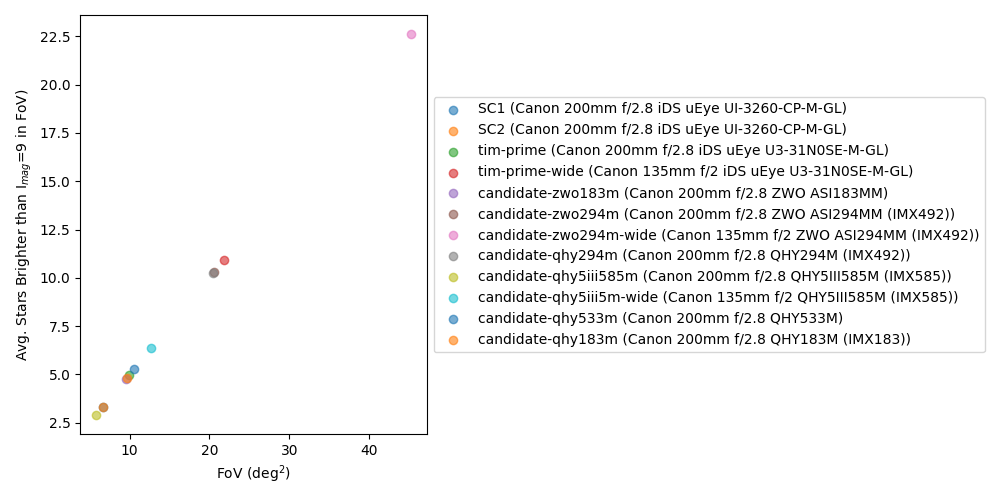

In [90]:
I_band_stars_per_deg2 = 0.5 / u.deg**2

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    ax.scatter(cam.fov[0] * cam.fov[1], (cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2, label=f'{cam.name} ({cam.lens.name} {cam.sensor.name})', alpha=0.6)
    print(f'{cam.name}: {cam.fov} -> {cam.fov[0] * cam.fov[1]} -> {(cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2} stars')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel('FoV (deg$^2$)')
ax.set_ylabel('Avg. Stars Brighter than I$_{mag}$=9 in FoV)')
fig.tight_layout()

For a total mission time of 512.0 h, @ cadence 3.0 s:
SC1: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
SC2: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
tim-prime: 16.2 MP, 16.20 MB per pic, 9952 GB total storage
tim-prime-wide: 16.2 MP, 16.20 MB per pic, 9952 GB total storage
candidate-zwo183m: 20.2 MP, 30.27 MB per pic, 18599 GB total storage
candidate-zwo294m: 11.7 MP, 20.47 MB per pic, 12574 GB total storage
candidate-zwo294m-wide: 11.7 MP, 20.47 MB per pic, 12574 GB total storage
candidate-qhy294m: 11.6 MP, 17.46 MB per pic, 10730 GB total storage
candidate-qhy5iii585m: 8.4 MP, 12.61 MB per pic, 7747 GB total storage
candidate-qhy5iii5m-wide: 8.4 MP, 12.61 MB per pic, 7747 GB total storage
candidate-qhy533m: 9.1 MP, 15.94 MB per pic, 9793 GB total storage
candidate-qhy183m: 20.4 MP, 40.85 MB per pic, 25097 GB total storage


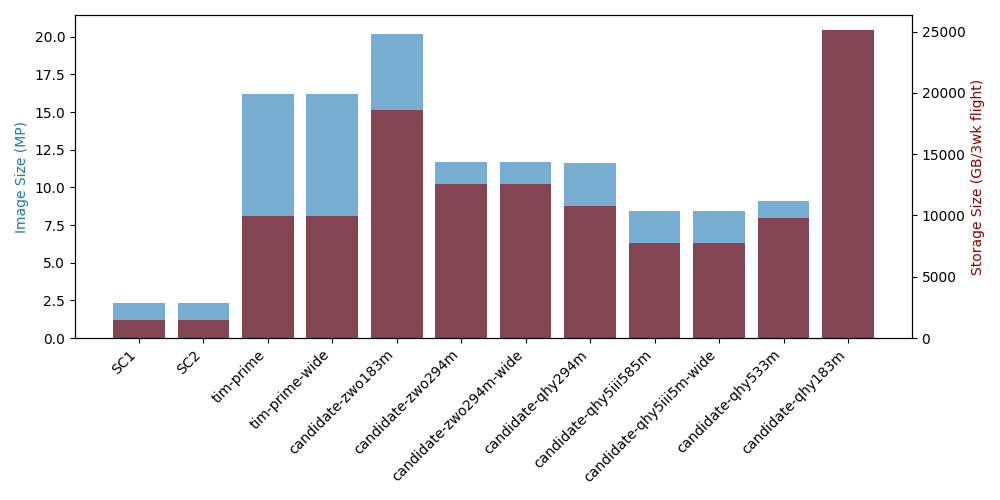

In [91]:
float_time = 8 * 3600 * u.s + (3 * 7 * 24 * 3600) * u.s
cadence = 3 * u.s
num_pics = float_time / cadence
print(f'For a total mission time of {float_time * (u.hr / (3600. * u.s))}, @ cadence {cadence}:')
for cam in cams:
    print(f'{cam.name}: {cam.sensor.megapixels:.1f} MP, {cam.sensor.frame_storage_size / 1e6 / 8:.2f} MB per pic, {num_pics * cam.sensor.frame_storage_size / 1e6 / 8 / 1000:.0f} GB total storage')

fig, megapix = plt.subplots(figsize=(10,5))
megapix.bar([cam.name for cam in cams], [cam.sensor.megapixels for cam in cams], color='C0', alpha=0.6)
megapix.set_ylabel('Image Size (MP)')
megapix.yaxis.label.set_color('C0')
plt.xticks(rotation=45, ha='right')
storage = megapix.twinx()
storage.bar([cam.name for cam in cams], [(num_pics * cam.sensor.frame_storage_size / 1e6 / 8 / 1000) for cam in cams], color='darkred', alpha=0.6)
storage.set_ylabel('Storage Size (GB/3wk flight)')
storage.yaxis.label.set_color('darkred')
fig.tight_layout()

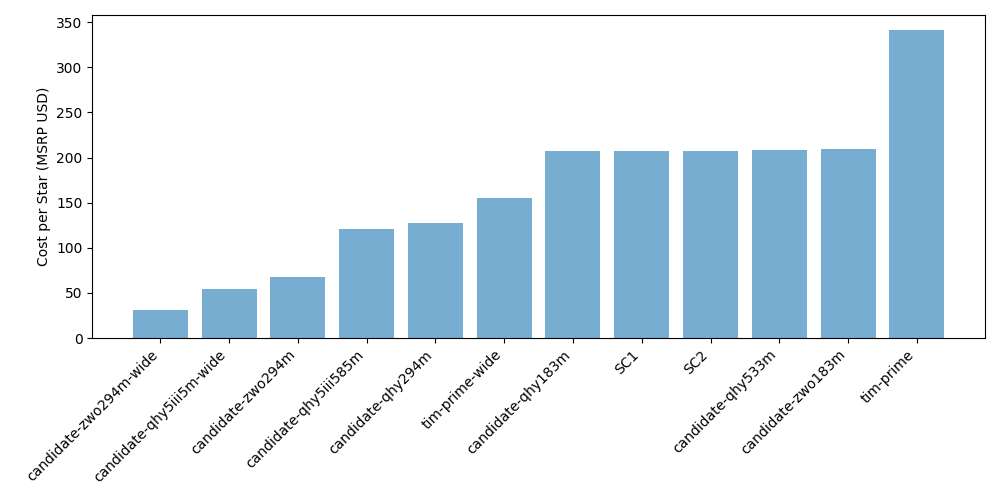

In [92]:
fig, cost = plt.subplots(figsize=(10,5))
cost_sort = np.argsort([cam.sensor.cost / ((cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2) for cam in cams])
cost.bar(
    [cams[i].name for i in cost_sort],
    [cams[i].sensor.cost / ((cams[i].fov[0] * cams[i].fov[1]) * I_band_stars_per_deg2) for i in cost_sort],
    color='C0',
    alpha=0.6
)
cost.set_ylabel('Cost per Star (MSRP USD)')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

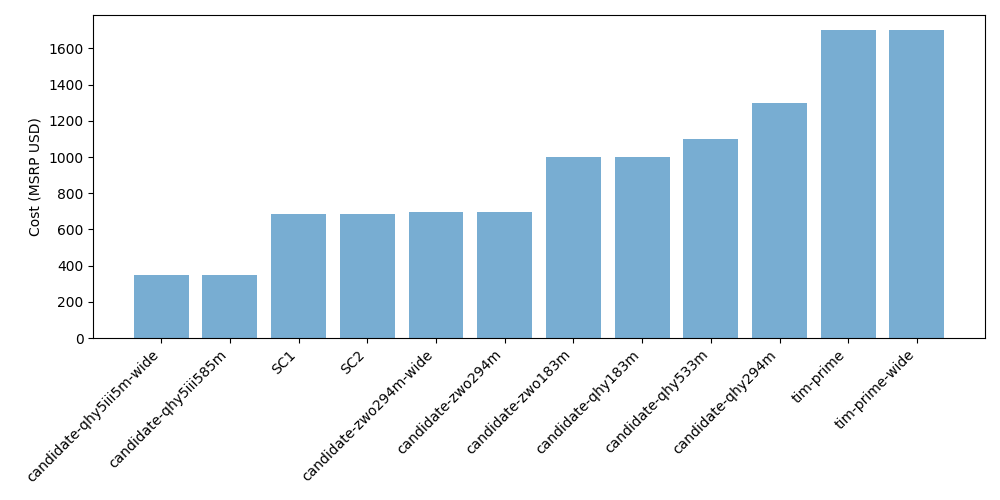

In [93]:
fig, cost = plt.subplots(figsize=(10,5))
cost_sort = np.argsort([cam.sensor.cost for cam in cams])
cost.bar([cams[i].name for i in cost_sort], [cams[i].sensor.cost for i in cost_sort], color='C0', alpha=0.6)
cost.set_ylabel('Cost (MSRP USD)')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

### Recommendations

#### TIM Science Flight

For TIM science flight, I recommend choosing the iDS uEye U3-31N0SE-M-GL. It should net ~5 stars on average over a 10deg^2 FoV at SNR > 2. It has the highest cost overall and highest cost per star, but shooting in 8bit allows us to avoid extensive rewriting of existing software and tamps down the data storage problem to a single ~12 TB drive in flight.

An additional ~40% SNR boost for any of these sensors could be gained by switching to an f/2 lens. We would have to buy secondhand lenses, and re-buy filters for the filter drawers on the f/2 lens; the front element is so large that filters are impractical and are instead installed at the rear.

I do not recommend further filtering into the IR - Si-based sensors' QE limitations at ~1000 nm mean that further filtering decreases the total number of photons available from stars enough to begin eating into SNR, despite the reduction in background.

#### New Development

If new development is allowed for risk reduction, I propose developing a "widefield" option: A Canon 200mm f/2.8 EF lens coupled via the same Birger focuser to a ZWO ASI294MM.

Advantages:
* Wide FoV: ~20.6deg^2, ~10.3 stars, drastically improving chances of successful plate solve
* Sufficient SNR over wider field than TIM test flight due to smaller pixels and higher red QE
* Low data storage requirements
* Software rewrite an opportunity to use more ADC bits, diversify codebase to amortize risk
* Small cost per star

Risks:
* Software rewrite for ZWO API
* Software effort to adhere to existing flight software interfaces
* Increased storage requirements

Risk Mitigations:
* Double exposure time to 0.2s to increase SNR from 4.6 um pixel mismatch
* Run widefield SC at lower cadence to reduce storage requirements
* Existing ZWO C/Python API examples
* ECM has working Python tetra3 plate solver